In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
from core import *
import open3d as o3d
from open3d import io, visualization

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = io.read_triangle_mesh("../assets/kidney_phantom/00_abdomen_cropped.obj")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)

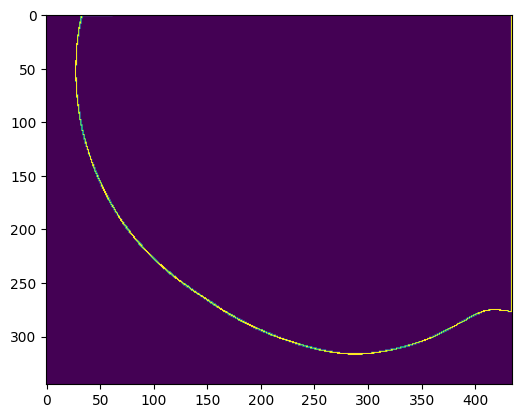

In [ ]:
plt.imshow(body_mask[:, :, 200])

In [ ]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=40, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=5, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=30, scale=0.0001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=0, scale=0.0001, label=6)
bone = tissue.Tissue(name='bone', c=2500, rho=1800, sigma=0, scale=0.0001, label=7)
# skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=8)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=9)

kidney_file_dir = "../assets/kidney_phantom/"
kidney_tissue_list = [fat, muscle, muscle, bone, connective, cortex, blood, blood, medulla]

# test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added fat
Added muscle
Added muscle
Added bone
Added connective_tissue
Added renal_cortex
Added blood
Added blood
Added renal_medulla


In [ ]:
test_phantom.get_complete().shape

(2, 345, 435, 416)

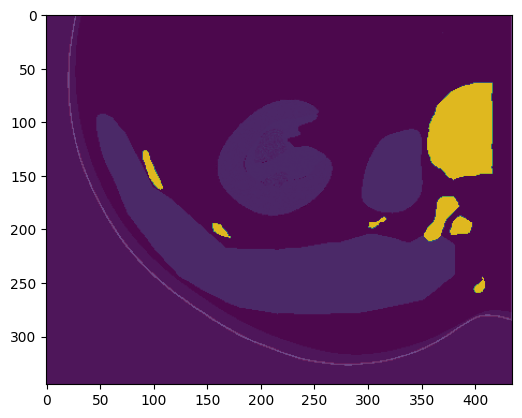

In [ ]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200])
plt.imshow(body_mask[:,:, 250] * 1000, alpha=0.2, cmap='Reds_r')

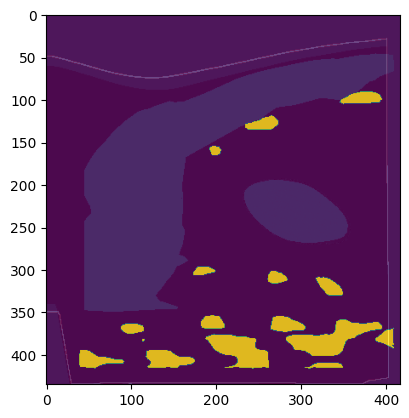

In [ ]:
plt.imshow(test_phantom.get_complete()[0, 200, :, :])
plt.imshow(body_mask[180,:, :] * 1000, alpha=0.2, cmap='Reds_r')

In [ ]:
num_transducers = 1
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 3, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 20e-3,
#                                     ) for i in range(num_transducers)]

transducers = [transducer.Focused(max_frequency = 1e6,
                                  elements = 128, 
                                  width = 40e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 64,
                                  imaging_ndims = 2,
                                  focus_azimuth = 100e-3,
                                  focus_elevation = 100e-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [ ]:
pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[200,100,200], voxel_size[0])
pt = np.array([pt[0], pt[1], pt[2]])
normal = -np.array([normal[0], normal[1], normal[2]])

pose = geometry.Transform.make_from_heading_vector(normal, pt)

theta = -np.pi/2
# theta = 0
about_nl_axis = geometry.Transform(rotation=tuple(theta*normal), translation=(0,0,0), about_axis=True)

transducer_pose = about_nl_axis * pose

test_transducer_set.assign_pose(0, transducer_pose)


In [ ]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [ ]:
np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test_phantom.matrix_dims)/2

array([212.5660485 ,  86.8472296 , 197.01712894])

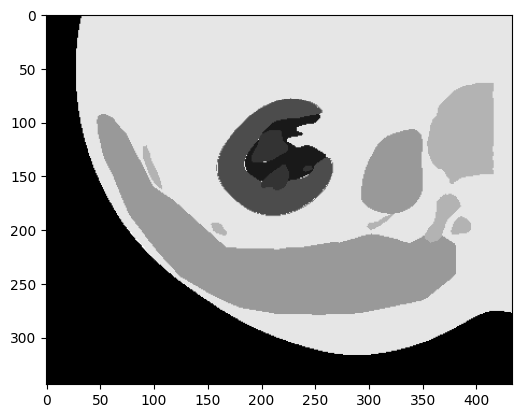

In [ ]:
test_sensor.visualize(test_phantom, index=[slice(0, -1, 1), slice(0, -1, 1), 198], body_surface_mask=body_mask)

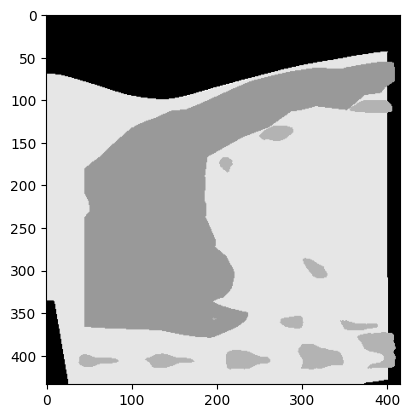

In [ ]:
test_sensor.visualize(test_phantom, index=[212, slice(0, -1, 1), slice(0, -1, 1)], body_surface_mask=body_mask)

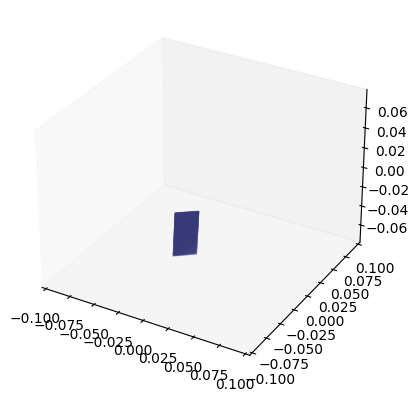

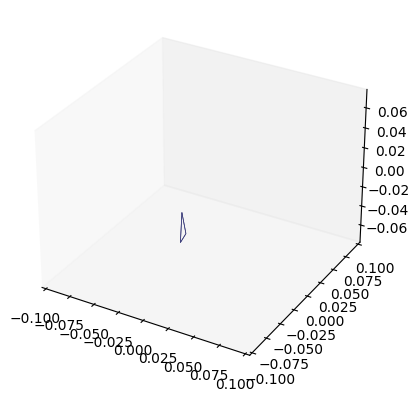

In [ ]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [14]:
simprops = simulation.SimProperties(
                grid_size   = (150e-3,80e-3,80e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [15]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/kidney_experiment_02',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

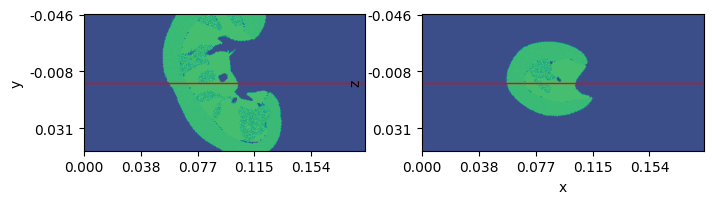

In [16]:
test_experiment.plot_ray_path(31)

In [17]:
test_experiment = experiment.Experiment.load('../experiment_files/kidney_experiment_02')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


In [ ]:
test_experiment.run(repeat=True)

In [25]:
test_experiment.add_results()

In [26]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [27]:
test_reconstruction.transducer_set[0]

(<transducer.Focused at 0x71b9a3a4bf70>,
 <geometry.Transform at 0x71b9a0d517f0>)

In [28]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.1, workers=4, tgc=7)

100%|██████████| 64/64 [00:52<00:00,  1.21it/s]
1it [00:00,  4.84it/s]


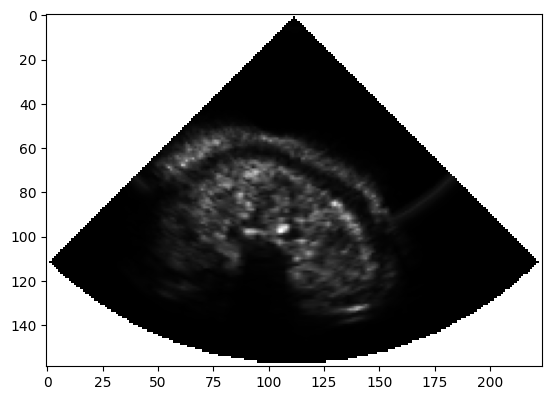

In [29]:
plt.imshow(signals[0],)

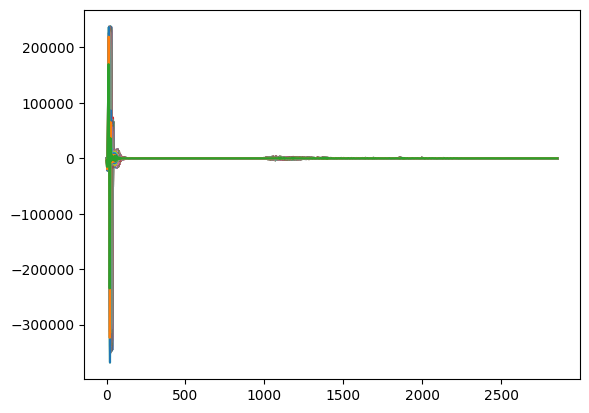

In [24]:
plt.plot(test_reconstruction.results[32][1].T)